In [781]:
import sys, os
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

# Use below for charts in dark jupyter theme

font_size = '20.0'
dark_theme_config = {
    "ytick.color" : "w",
    "xtick.color" : "w",
    "text.color": "white",
    'font.size': font_size,
    'axes.titlesize': font_size,
    'axes.labelsize': font_size, 
    'xtick.labelsize': font_size, 
    'ytick.labelsize': font_size, 
    'legend.fontsize': font_size, 
    'figure.titlesize': font_size,
    'figure.figsize': [20, 7],
    'figure.facecolor': "#384151",
    'legend.facecolor': "#384151",
    "axes.labelcolor" : "w",
    "axes.edgecolor" : "w"
}
plt.rcParams.update(dark_theme_config)

sys.path.append("..")

import xai
import xai.data

In [782]:
csv_path = 'data/adult.data'
categorical_cols = ["gender", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "loan"]
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "loan"]

In [783]:
df = xai.data.load_census()
df["loan"] = df["loan"].apply(lambda x: x == " >50K")
df.tail()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,loan
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,False
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,True
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,False
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,False
32560,52,Self-emp-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,True


In [784]:
target = "loan"
protected = ["ethnicity", "gender", "age"]

       'relationship', 'ethnicity', 'gender', 'loan'],
      dtype='object'). If you see an error these are not correct, please provide them as a string array as: categorical_cols=['col1', 'col2', ...]


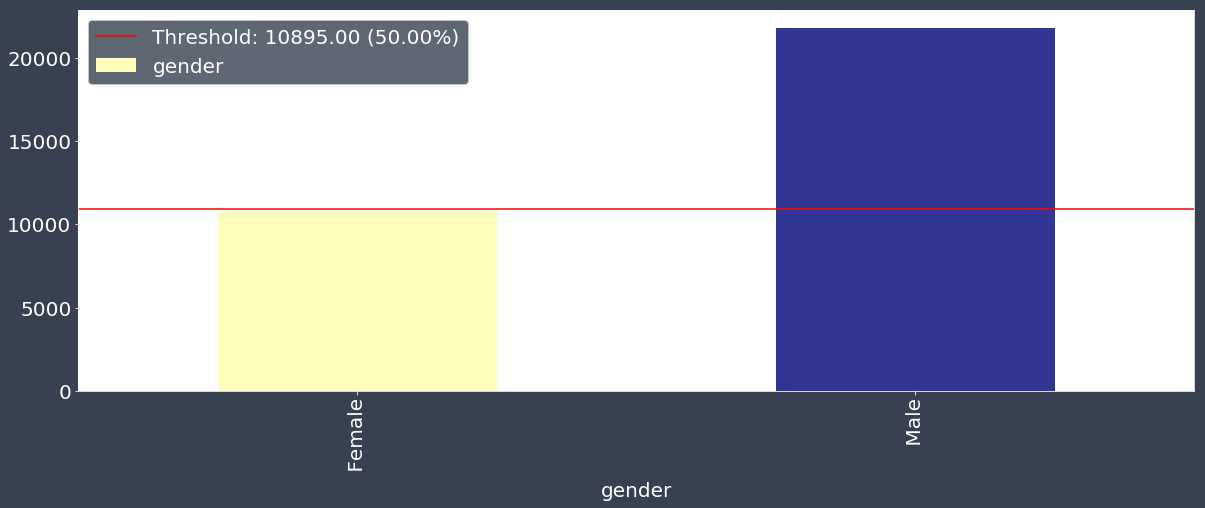

In [785]:
df_groups = xai.show_imbalance(df, "gender")

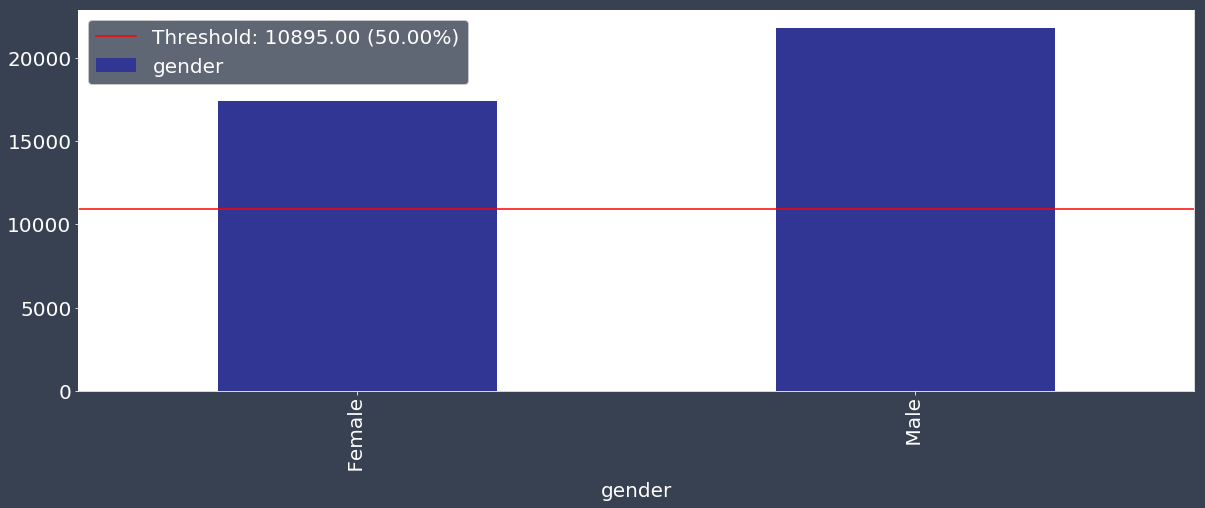

In [786]:
bal_df = xai.balance(df, "gender", upsample=0.8)

       'relationship', 'ethnicity', 'gender', 'loan'],
      dtype='object'). If you see an error these are not correct, please provide them as a string array as: categorical_cols=['col1', 'col2', ...]


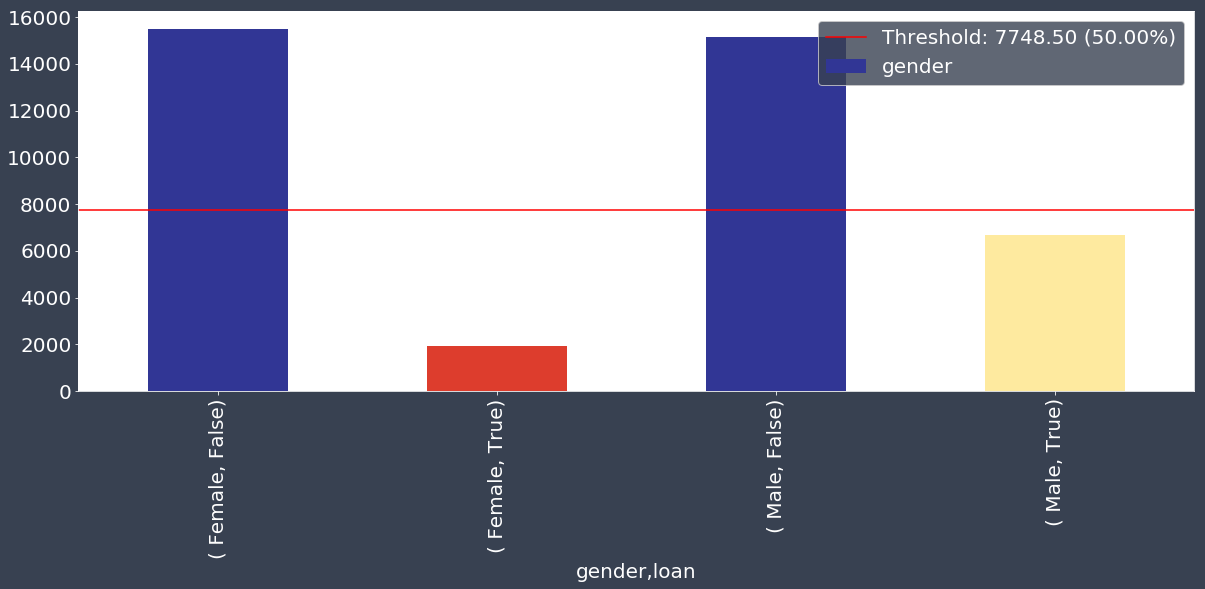

In [791]:
groups = xai.imbalance_plot(bal_df, "gender", "loan")

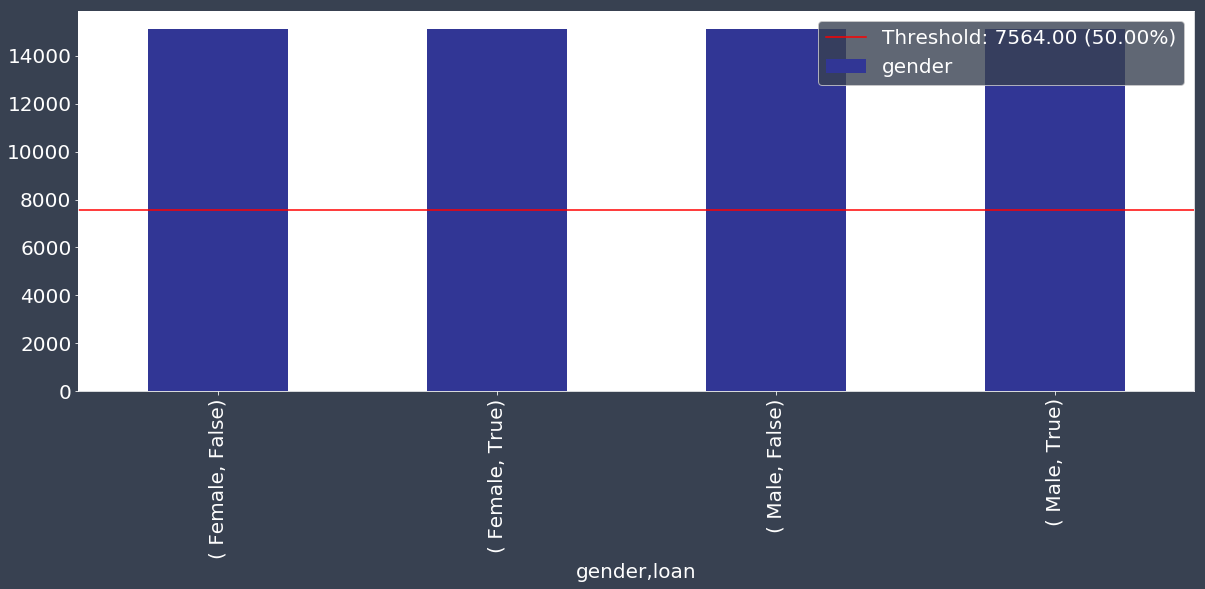

In [793]:
bal_df = xai.balance(df, "gender", "loan", upsample=1)

/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


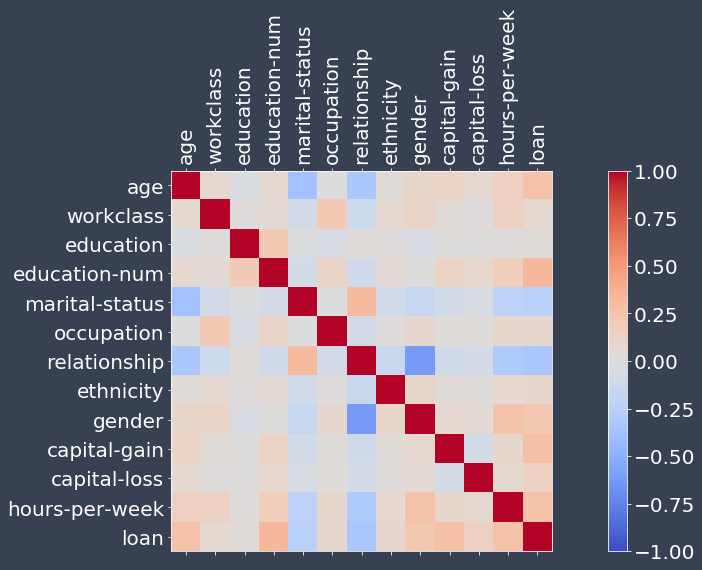

In [702]:
_ = xai.correlations(df, include_categorical=True, plot_type="matrix")

/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


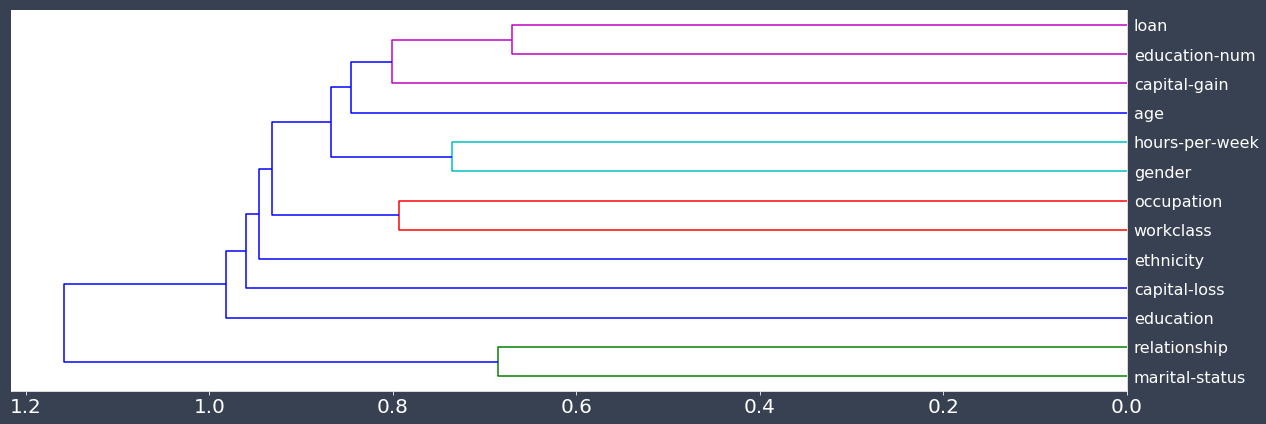

In [780]:
_ = xai.correlations(df, include_categorical=True)

In [602]:
proc_df = xai.normalize_numeric(bal_df)
proc_df = xai.convert_categories(proc_df)
x = proc_df.drop("loan", axis=1)
y = proc_df["loan"]

x_train, y_train, x_test, y_test, train_idx, test_idx = \
    xai.balanced_train_test_split(
            x, y, cross=["gender"], 
            categorical_cols=categorical_cols, min_per_class=300,
            fallback_type="half")

x_train_display = bal_df[train_idx]
x_test_display = bal_df[test_idx]

print(x_test.shape)

(1200, 12)


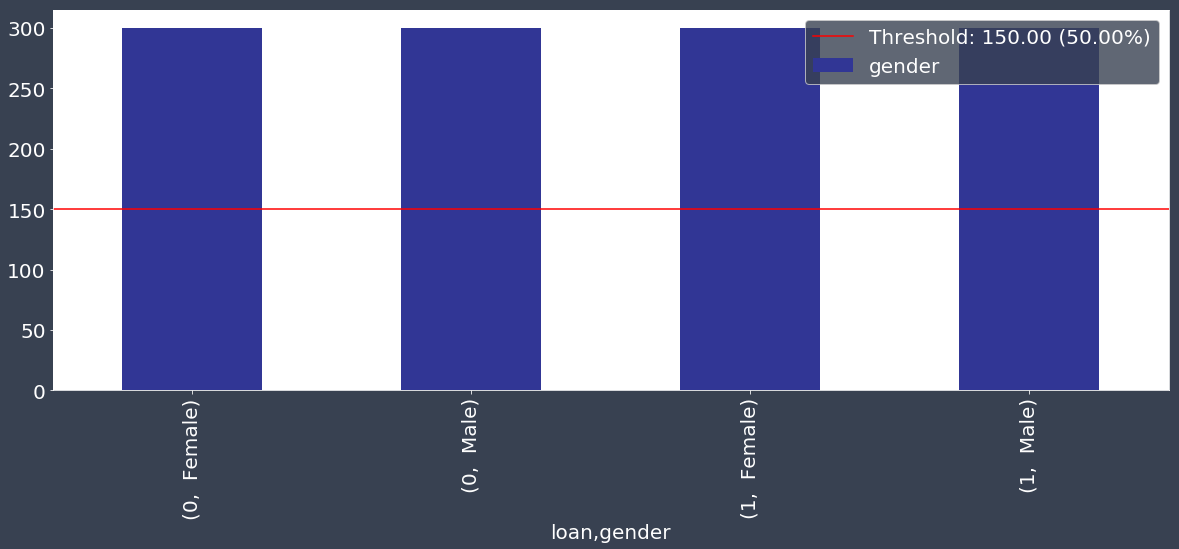

In [604]:
df_test = x_test_display.copy()
df_test["loan"] = y_test

_= xai.show_imbalance(df_test, "gender", cross=["loan"], categorical_cols=categorical_cols)

In [607]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc

from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(X[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model


def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs, threshold=0.5):
    """Convert probabilities into classes"""
    return list((probs >= threshold).astype(int).T[0])


In [608]:
model = build_model(x_train)

model.fit(f_in(x_train), y_train, epochs=50, batch_size=512)

Epoch 1/50
59312/59312 [==============================] - 2s 35us/step - loss: 0.5556 - acc: 0.7139
Epoch 2/50
59312/59312 [==============================] - 0s 8us/step - loss: 0.4132 - acc: 0.8111
Epoch 3/50
59312/59312 [==============================] - 0s 8us/step - loss: 0.3813 - acc: 0.8261
Epoch 4/50
59312/59312 [==============================] - 1s 8us/step - loss: 0.3753 - acc: 0.8281
Epoch 5/50
59312/59312 [==============================] - 1s 9us/step - loss: 0.3723 - acc: 0.8282
Epoch 6/50
59312/59312 [==============================] - 1s 10us/step - loss: 0.3692 - acc: 0.8300
Epoch 7/50
59312/59312 [==============================] - 1s 9us/step - loss: 0.3679 - acc: 0.8306
Epoch 8/50
59312/59312 [==============================] - 1s 9us/step - loss: 0.3665 - acc: 0.8315
Epoch 9/50
59312/59312 [==============================] - 1s 9us/step - loss: 0.3659 - acc: 0.8314
Epoch 10/50
59312/59312 [==============================] - 1s 9us/step - loss: 0.3648 - acc: 0.8310
Epoch 1

In [609]:
score = model.evaluate(f_in(x_test), y_test, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

1200/1200 [==============================] - 1s 512us/step
Error 0.3243: 
Accuracy 85.6667: 


In [610]:
probabilities = model.predict(f_in(x_test))
pred = f_out(probabilities)

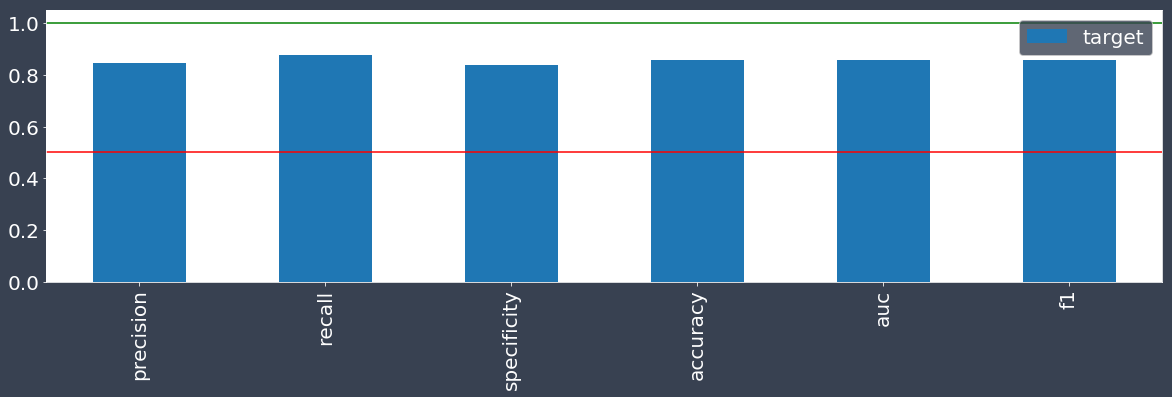

In [611]:
_= xai.metrics_plot(
        y_test, 
        probabilities)

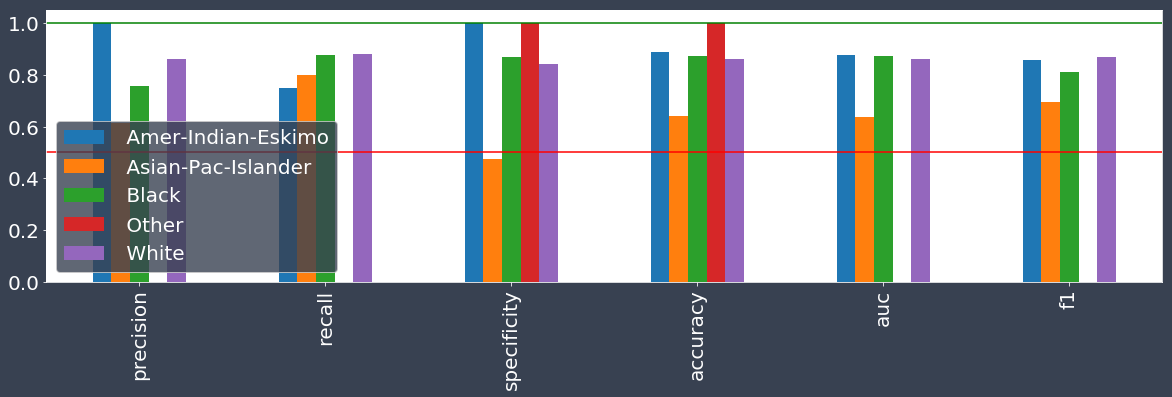

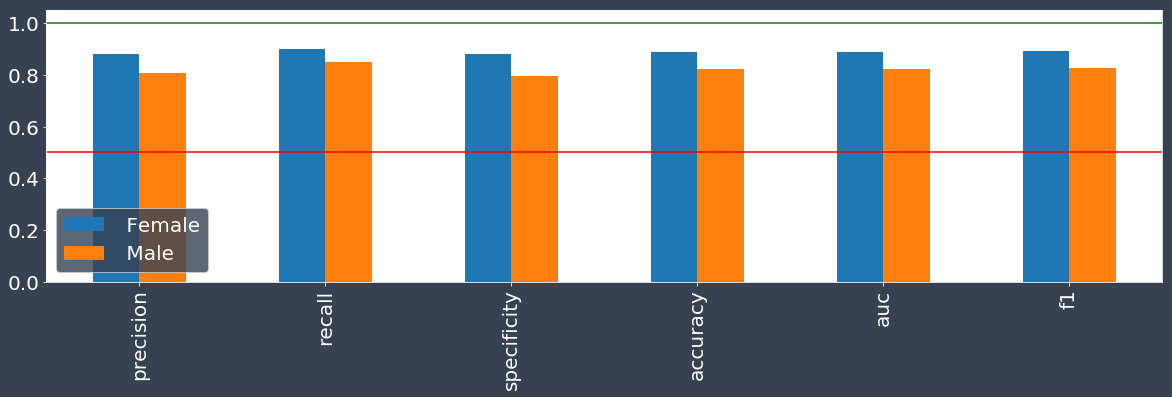

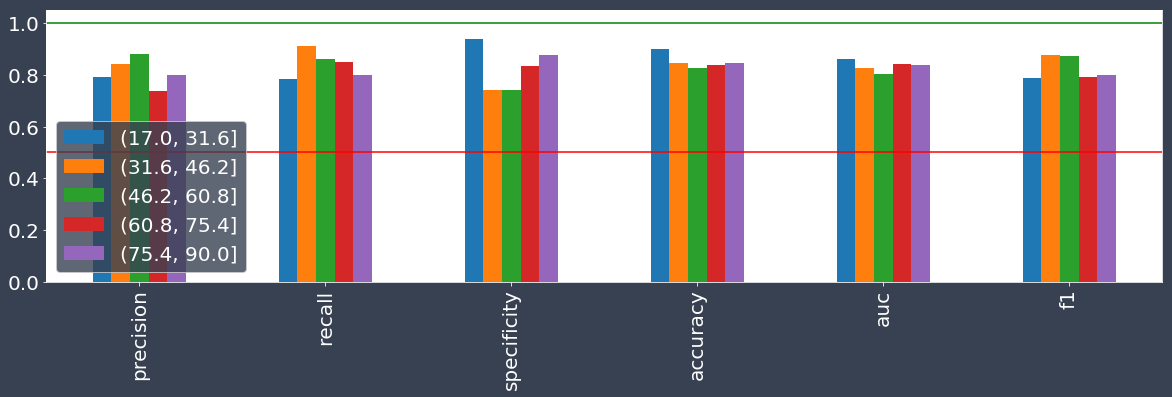

In [612]:
_ = [xai.metrics_plot(
    y_test, 
    probabilities, 
    df=x_test_display, 
    cross_cols=[p],
    categorical_cols=categorical_cols) for p in protected]

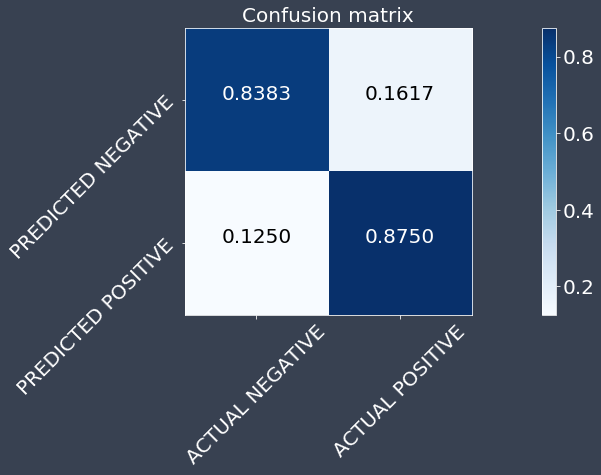

In [690]:
xai.confusion_matrix_plot(y_test, pred)

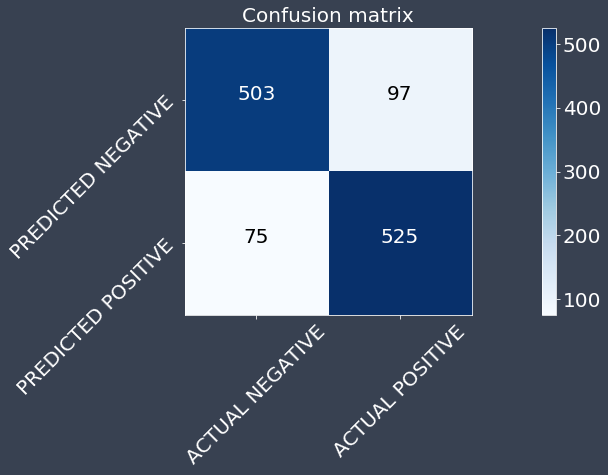

In [691]:
xai.confusion_matrix_plot(y_test, pred, scaled=False)

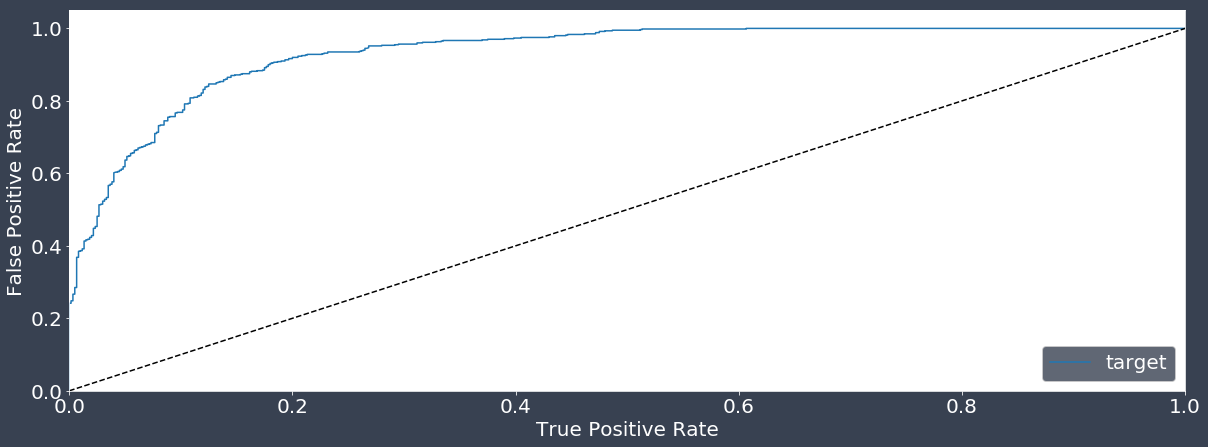

In [667]:
_ = xai.roc_plot(y_test, probabilities)

/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


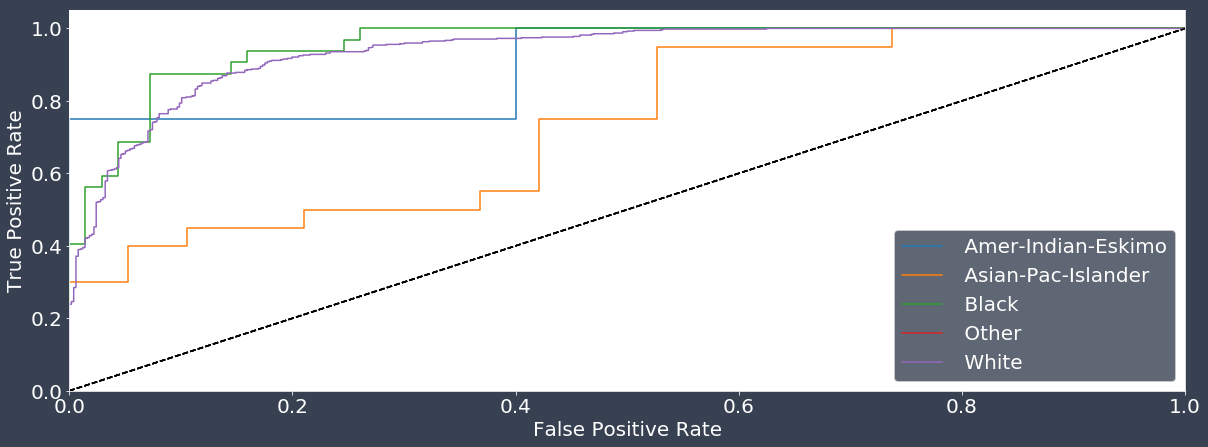

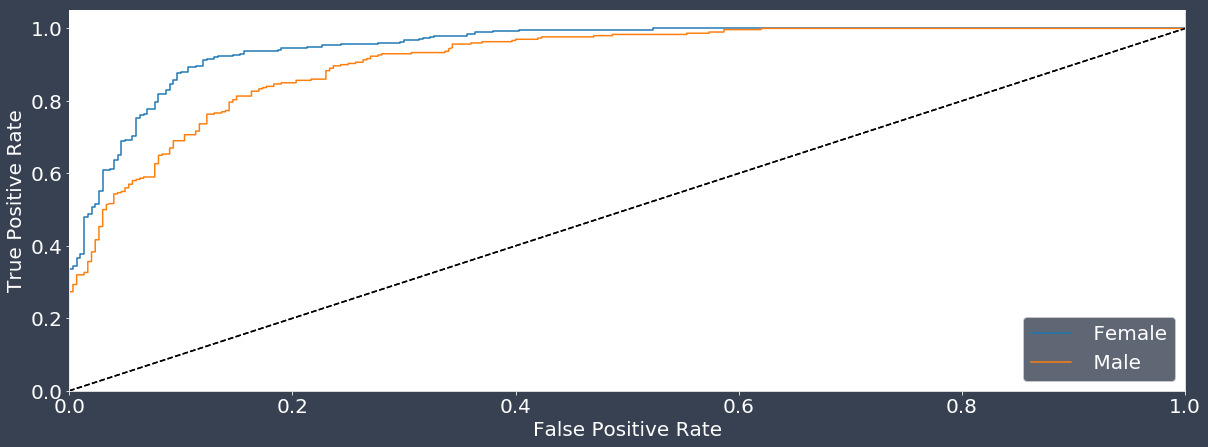

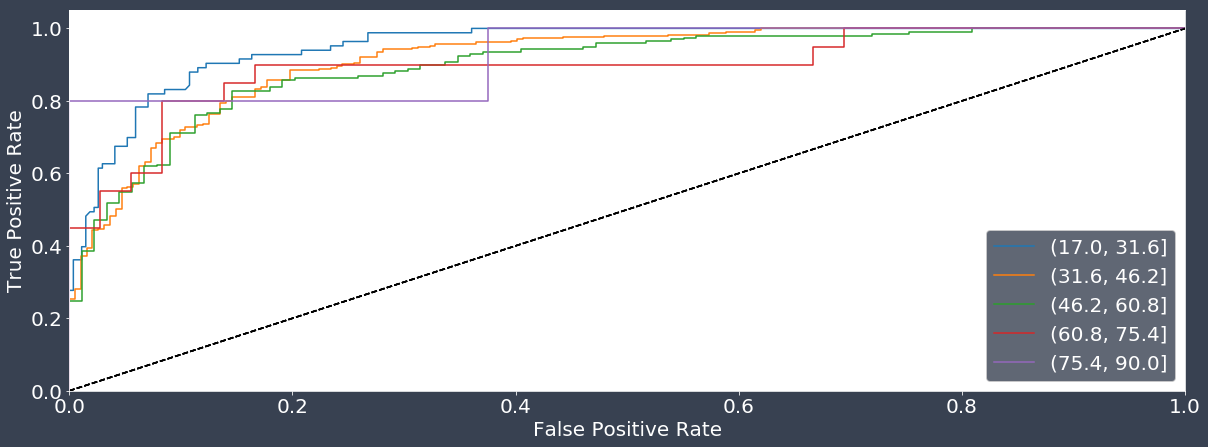

In [614]:
_ = [xai.roc(
    y_test, 
    probabilities, 
    df=x_test_display, 
    cross_cols=[p],
    categorical_cols=categorical_cols) for p in protected]

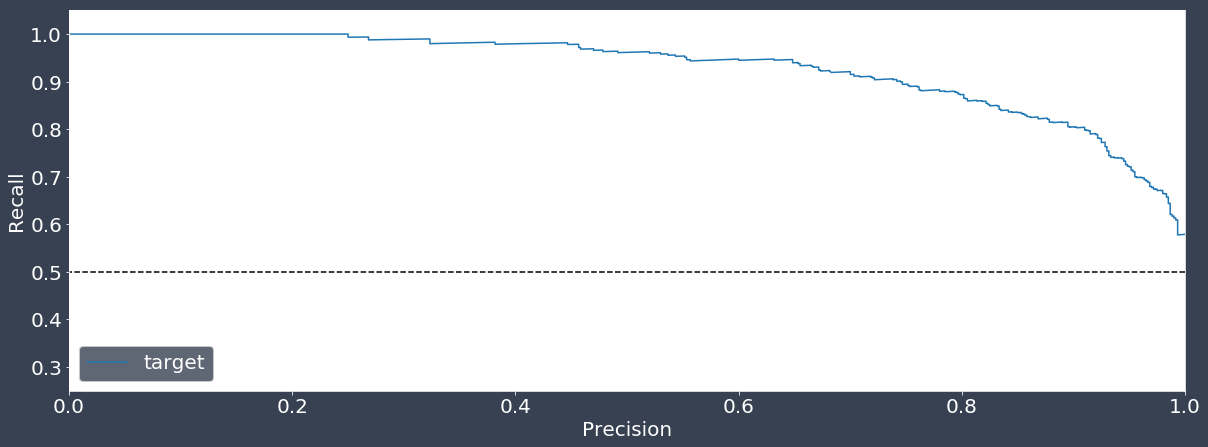

In [555]:
_= xai.pr_plot(y_test, probabilities)

/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


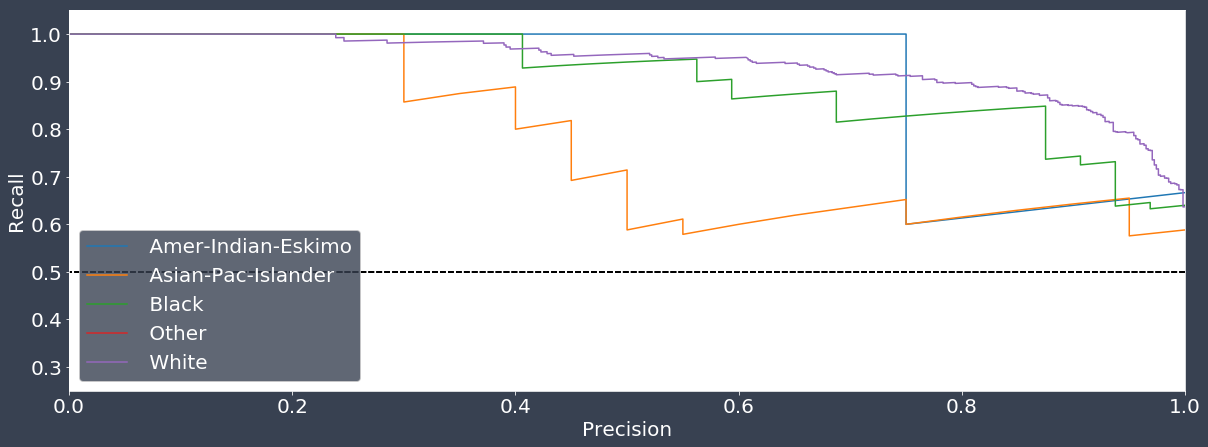

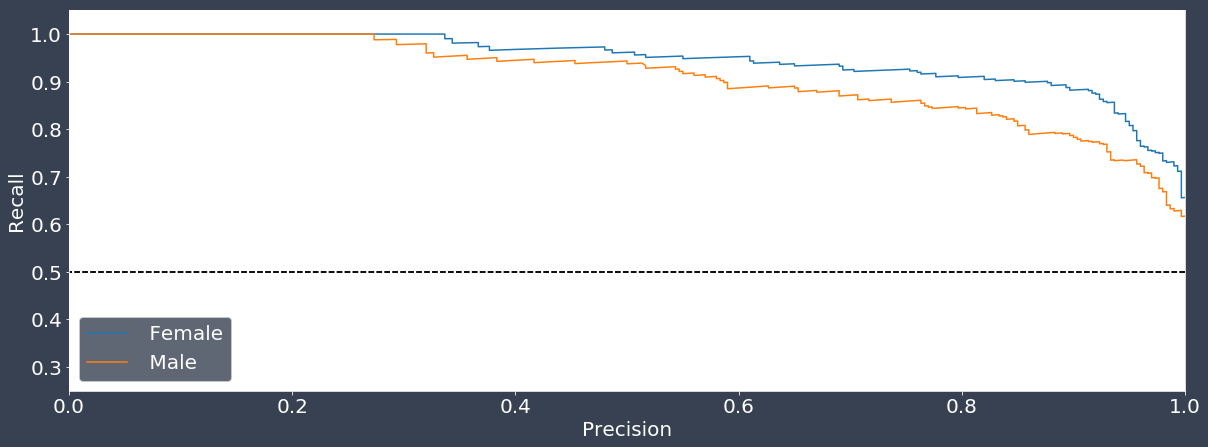

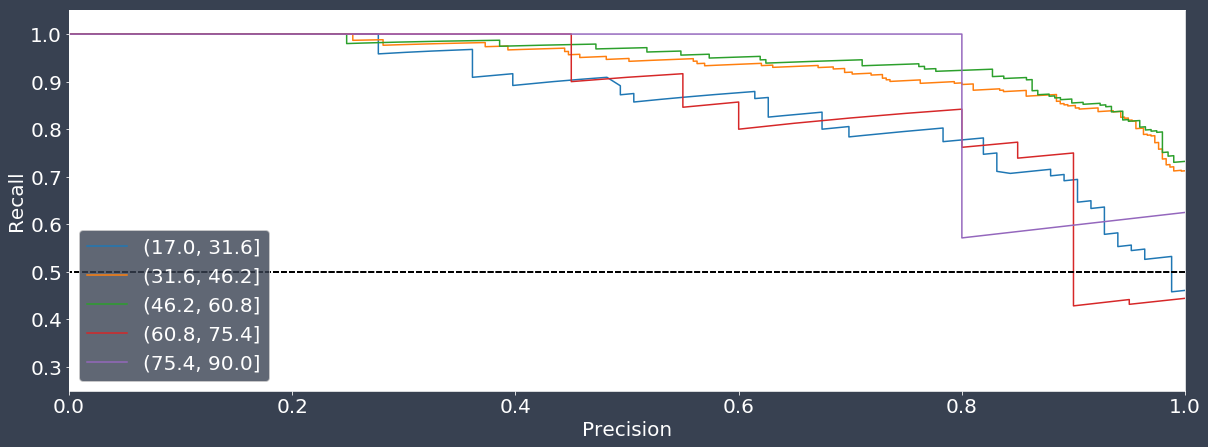

In [615]:
_ = [xai.pr_plot(
    y_test, 
    probabilities, 
    df=x_test_display, 
    cross_cols=[p],
    categorical_cols=categorical_cols) for p in protected]

/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


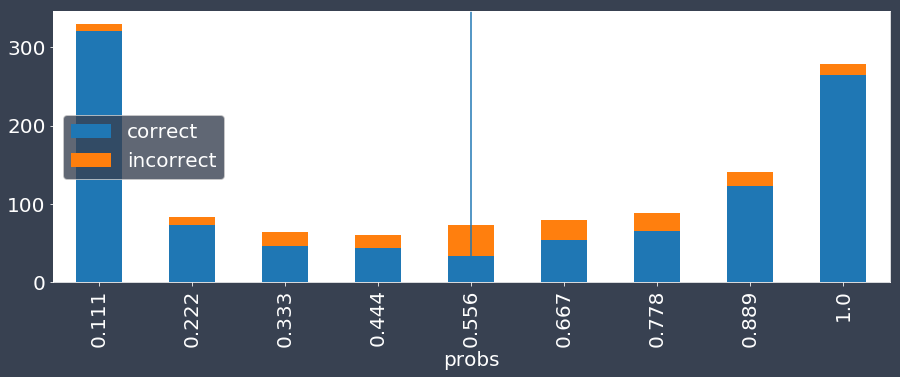

In [616]:
d = xai.smile_imbalance(
    y_test, 
    probabilities)

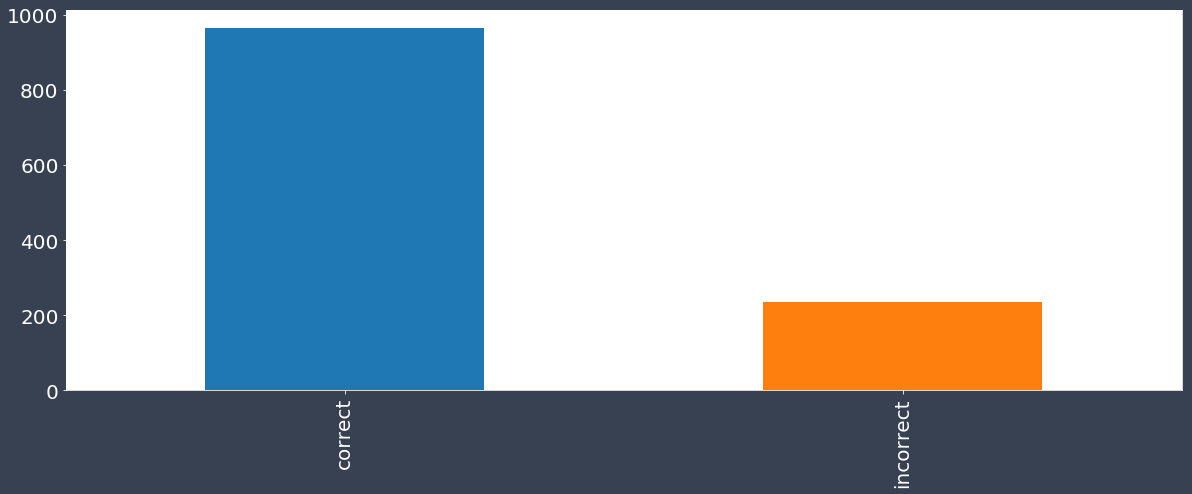

In [648]:
d[["correct", "incorrect"]].sum().plot.bar()

/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


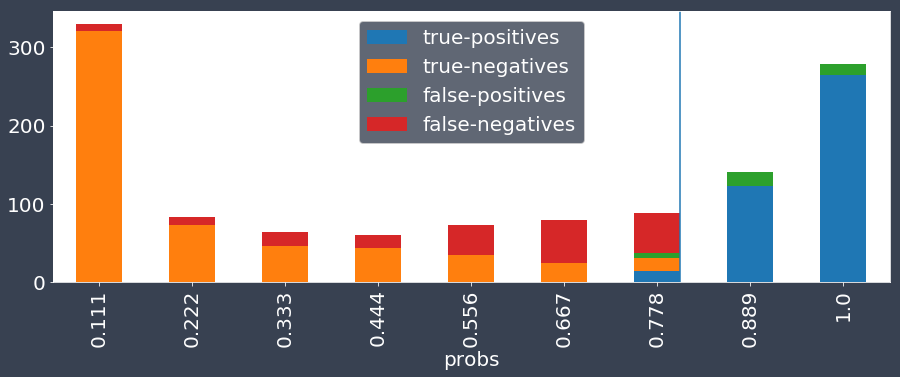

In [649]:
d = xai.smile_imbalance(
    y_test, 
    probabilities,
    threshold=0.75,
    display_breakdown=True)

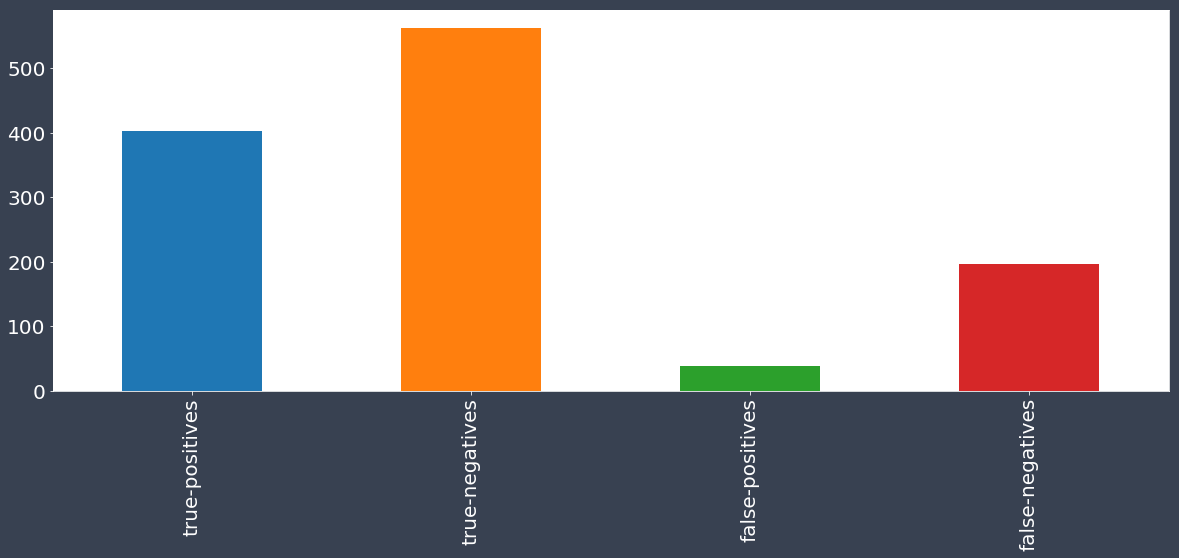

In [651]:
display_bars = ["true-positives", "true-negatives", 
                "false-positives", "false-negatives"]
d[display_bars].sum().plot.bar()

/home/alejandro/anaconda3/envs/xai/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


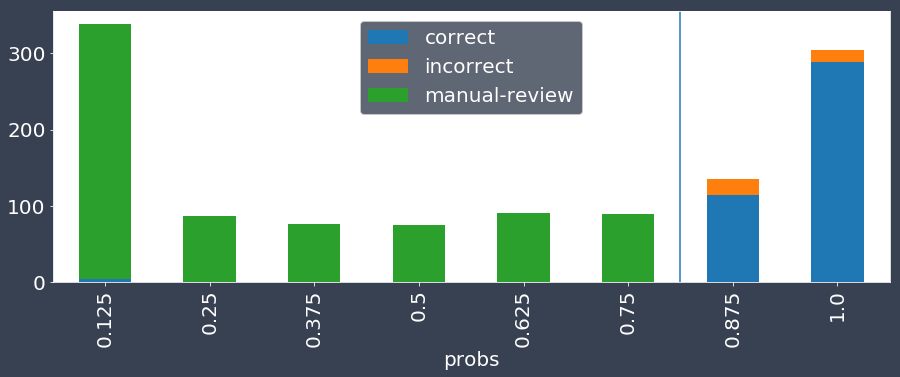

In [652]:
d = xai.smile_imbalance(
    y_test, 
    probabilities,
    bins=9,
    threshold=0.75,
    manual_review=0.00001,
    display_breakdown=False)

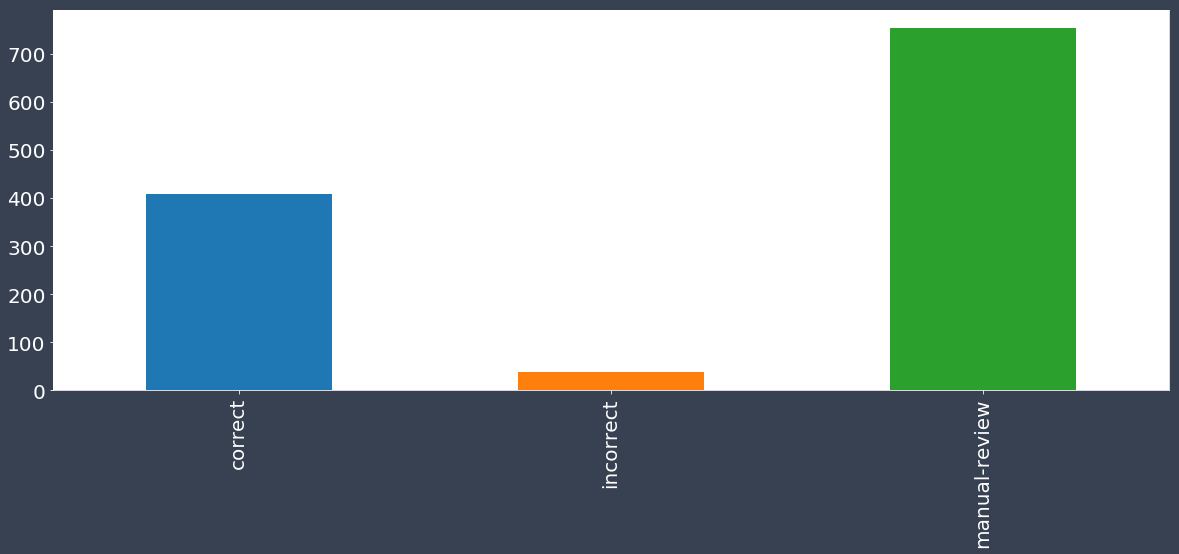

In [653]:
d[["correct", "incorrect", "manual-review"]].sum().plot.bar()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week
0,0.029917,-0.002083,0.000583,0.04675,0.08625,0.01925,0.028167,0.00225,0.0075,0.0425,-0.000417,0.024667


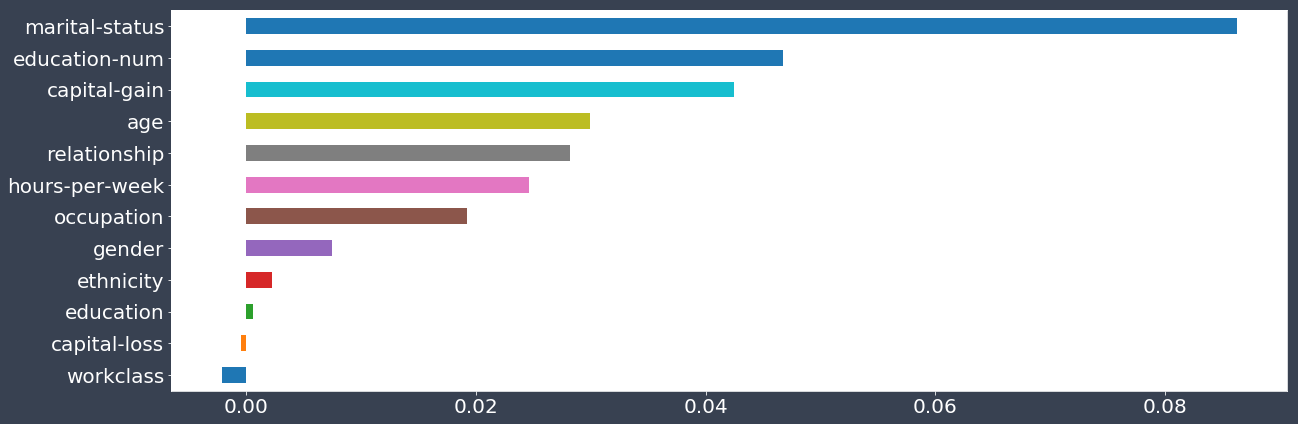

In [620]:
def get_avg(x, y):
    return model.evaluate(f_in(x), y, verbose=0)[1]

imp = xai.feature_importance(x_test, y_test, get_avg)

imp.head()